In [1]:
import numpy as np
from scipy.spatial.distance import cdist
from functools import reduce

from gproc.generative import sample_at_x
import matplotlib.pyplot as plt

In [2]:
# Data sizes and dimension
D = 2
N = 50
M = 25

x_1 = np.random.uniform(-1, 1, N * D).reshape(-1, D) # Reshape to N x D matrix
x_2 = np.random.uniform(-1, 1, M * D).reshape(-1, D) # Reshape to N x D matrix

In [3]:
def squared_exponential(x_1, x_2, lengthscale=0.5, variance=1.0):
    """
    Also known as RBF.
    
    :param x_1, N x d matrix
    :param x_2, M x d matrix

    :param lengthscale, float
    :param variance, float

    :returns K, N x M matrix, K_{ij} = k(x_i, x_j; lengthscale, variance)
    """
    sq_diffs = cdist(x_1, x_2, metric = 'sqeuclidean')
    return variance * np.exp(-0.5 * sq_diffs / lengthscale)

squared_exponential(x_1, x_2).shape

(50, 25)

In [4]:
def rational_quadratic(x_1, x_2, lengthscale=0.5, variance=1.0, weighting=1.0):
    """
    Rational Quadratic Kernel, equivalent to adding together many Squared Exponential kernels with different 
    lengthscales. Weight parameter determine relative weighting of large and small scale variations. When
    the weighting goes to infinity, RQ = SE.
    
    :param x_1, N x d matrix
    :param x_2, M x d matrix

    :param lengthscale, float
    :param variance, float
    :param weighting, float

    :returns K, N x M matrix, K_{ij} = k(x_i, x_j; lengthscale, variance, weighting)
    """
    sq_diffs = cdist(x_1, x_2, metric = 'sqeuclidean')
    return variance * ( (1 + sq_diffs / 2*lengthscale * weighting) ** (-weighting) )

rational_quadratic(x_1, x_2).shape

(50, 25)

In [5]:
def periodic(x_1, x_2, lengthscale=0.5, variance=1.0, period=1.0):
    """
    The periodic kernel allows one to model functions which repeat themselves exactly.
    
    :param x_1, N x d matrix
    :param x_2, M x d matrix

    :param lengthscale, float
    :param variance, float
    :param period, float

    :returns K, N x M matrix, K_{ij} = k(x_i, x_j; lengthscale, variance, period)
    """
    diffs = cdist(x_1, x_2, metric = 'euclidean')
    return variance * np.exp(-0.5 * np.sin(np.pi * diffs / period) / lengthscale)

periodic(x_1, x_2).shape

(50, 25)

In [6]:
def locally_periodic(x_1, x_2, lengthscale=0.5, variance=1.0, period=1.0):
    """
    A squared exponential kernel multiplied by a periodic kernel. Allows one to model periodic functions
    which can vary slowly over time.
    
    :param x_1, N x d matrix
    :param x_2, M x d matrix

    :param lengthscale, float
    :param variance, float
    :param period, float

    :returns K, N x M matrix, K_{ij} = k(x_i, x_j; lengthscale, variance, period)
    """
    
    return np.multiply(squared_exponential(x_1, x_2, lengthscale, variance), periodic(x_1, x_2, lengthscale, variance, period))

locally_periodic(x_1, x_2).shape

(50, 25)

In [7]:
def linear(x_1, x_2, constant_variance=0.5, variance=1.0, offset=1.0):
    """
    A linear kernel is a non-stationary kernel, which when used with a GP, is equivalent to
    Bayesian linear regression.
    
    :param x_1, N x d matrix
    :param x_2, M x d matrix

    :param constant_variance, float
    :param variance, float
    :param offset, float

    :returns K, N x M matrix, K_{ij} = k(x_i, x_j; constant_variance, variance, offset)
    """
    
    return constant_variance + variance*np.dot(x_1 - offset, x_2.T - offset)

linear(x_1, x_2).shape

(50, 25)

In [8]:
def add(x_1, x_2, kernels):
    """
    Add together an arbitrary number of kernels.
    
    :param x_1, N x d matrix
    :param x_2, M x d matrix
    
    :param kernels, tuple, tuple consisting of kernel functions, and corresponding parameter dictionaries
    
    :returns K, N x M matrix, sum of kernel matrices 
    """
    
    return sum([
        kernel(x_1, x_2, **kernel_kwargs)
        for kernel, kernel_kwargs in kernels
    ])

kernels = (
    (locally_periodic, {'lengthscale':0.5, 'variance':1.0, 'period':1.0}),
    (periodic, {'lengthscale':0.5, 'variance':1.0, 'period':0.1}),
)

add(x_1, x_2, kernels).shape

(50, 25)

In [24]:
def multiply(x_1, x_2, kernels):
    """
    Multiply together an arbitrary number of kernels.
    
    :param x_1, N x d matrix
    :param x_2, M x d matrix
    
    :param kernels, tuple, kernel functions and corresponding parameter dictionaries
    
    :returns K, N x M matrix, sum of kernel matrices 
    """
    
    grams = [kernel(x_1, x_2, **kernel_kwargs)
             for kernel, kernel_kwargs in kernels]
    
    return reduce(np.multiply, grams)

kernels = (
    (linear, {'constant_variance':0, 'variance':1.0, 'offset':0}),
    (periodic, {'lengthscale':0.5, 'variance':1.0, 'period':0.1}),
    (locally_periodic, {'lengthscale':0.5, 'variance':1.0, 'period':10})
    
)


multiply(x_1, x_2, kernels).shape

(50, 25)

In [22]:
x = np.random.uniform(-1, 1, N).reshape(-1, 1) # Reshape to N x 1 matrix
y, prob_y, f = sample_at_x(x, kernel_fcn = lambda x_1, x_2: multiply(x_1, x_2, kernels))

/home/tt21864/Documents/Bristol/Semester 2/Group Project/gproc/src/gproc/generative.py:15: RuntimeWarning: covariance is not positive-semidefinite.
  f = np.random.multivariate_normal(np.zeros(N), gram_matrix)


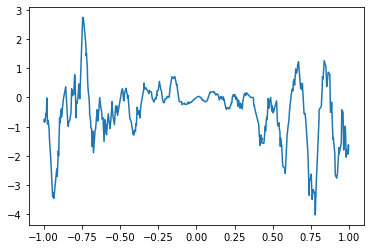

In [23]:
plt.plot(x[np.argsort(x.reshape(-1))], f[np.argsort(x.reshape(-1))])